In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

The human eye is most sensitive to green → highest weight (0.587)

Less sensitive to red → medium weight (0.299)

Least sensitive to blue → smallest weight (0.114)

So this formula produces grayscale images that look natural to human vision.

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [ ]:
img_rows

32

In [ ]:
img_cols

32

In [ ]:
channels

3

In [6]:
#) Create a folder and visualize test color images
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

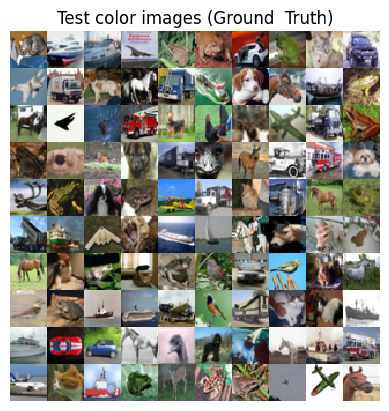

In [7]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [8]:
# Convert to grayscale and visualize
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)



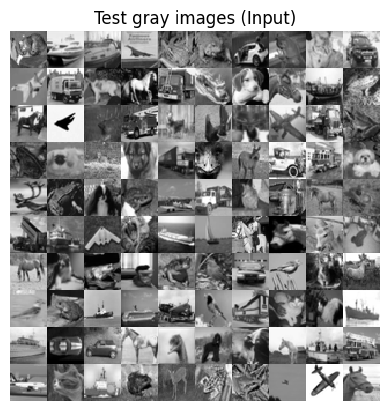

In [9]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [10]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [11]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

Input to the autoencoder: grayscale images x_train_gray (32x32x1)

Target/label: original color images x_train (32x32x3)

In [12]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [13]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [ ]:
#Build the encoder (convolutional)

In [ ]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [14]:
32*32

1024

In [ ]:
# Encoder:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [ ]:
x.shape

(None, 4, 4, 256)

32 × 32 × 1 = 1024
latent_dim = 256


Applies several convolution layers with stride 2 → downsamples the image (like encoding).

Flattens the last feature map and passes through a Dense layer to get a latent vector of size latent_dim.

shape stores the shape of the last conv feature map, needed to build the decoder.


In [ ]:
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

K.int_shape(x) converts them into real Python tuples

Output width = W / (2^n)

32 / (2^3) = 32 / 8 = 4



In [ ]:
shape

(None, 4, 4, 256)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,496 (5.41 MB)

 Trainable params: 1,418,496 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

we need to upsample so Conv2DTranspose

32x32 → 16x16 → 8x8 → 4x4    (downsampling)

4x4 → 8x8 → 16x16 → 32x32    (upsampling)



In [ ]:


# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,013,315 (7.68 MB)

 Trainable params: 2,013,315 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 256)            │     1,418,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │     2,013,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,431,811 (13.09 MB)

 Trainable params: 3,431,811 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
callbacks = [lr_reducer, checkpoint]

In [ ]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=15,
                batch_size=batch_size,
                callbacks=callbacks)


Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228
Epoch 1: val_loss improved from inf to 0.01087, saving model to /content/saved_models/colorized_ae_model.001.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0228 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/15
1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104
Epoch 2: val_loss improved from 0.01087 to 0.00952, saving model to /content/saved_models/colorized_ae_model.002.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0104 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 3/15
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093
Epoch 3: val_loss improved from 0.00952 to 0.00891, saving model to /content/saved_models/colorized_ae_model.003.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0093 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 4/15
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 4: val_loss improved from 0.00891 to 0.00833, saving model to /content/saved_models/colorized_ae_model.004.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0087 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 5/15
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082
Epoch 5: val_loss improved from 0.00833 to 0.00824, saving model to /content/saved_models/colorized_ae_model.005.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0082 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 6/15
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 6: val_loss improved from 0.00824 to 0.00799, saving model to /content/saved_models/colorized_ae_model.006.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0079 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/15
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 7: val_loss did not improve from 0.00799
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0076 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 8/15
1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073
Epoch 8: val_loss improved from 0.00799 to 0.00786, saving model to /content/saved_models/colorized_ae_model.008.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0073 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 9/15
1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 9: val_loss improved from 0.00786 to 0.00759, saving model to /content/saved_models/colorized_ae_model.009.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0071 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 10/15
1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 10: val_loss did not improve from 0.00759
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0069 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 11/15
1559/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 11: val_loss did not improve from 0.00759
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0066 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 12/15
1559/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064
Epoch 12: val_loss did not improve from 0.00759
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0064 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 13/15
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061
Epoch 13: val_loss did not improve from 0.00759
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0061 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 14/15
1563/1

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0053 - val_loss: 0.0076 - learning_rate: 3.1623e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


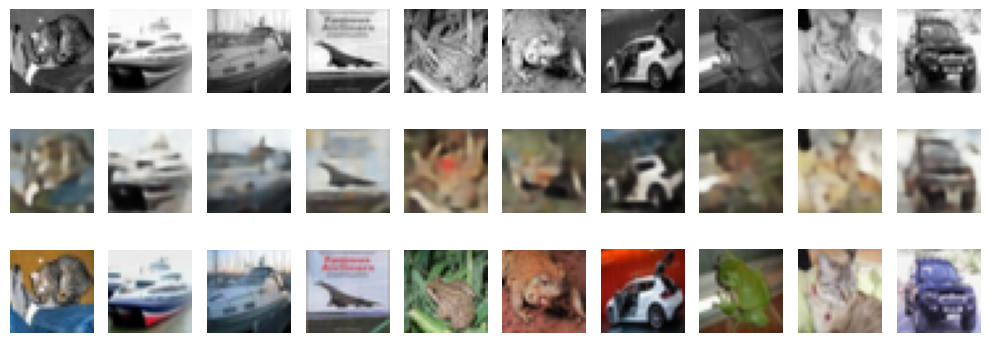

In [ ]:
import matplotlib.pyplot as plt

# pick some test images
n = 10
gray_examples = x_test_gray[:n]
color_gt = x_test[:n]

# get predictions
color_pred = autoencoder.predict(gray_examples)

# plot
plt.figure(figsize=(n, 4))

for i in range(n):
    # grayscale input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(gray_examples[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Input\n(gray)", fontsize=10)

    # reconstructed color
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(color_pred[i])
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Predicted\n(color)", fontsize=10)

    # ground truth color
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(color_gt[i])
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Ground\ntruth", fontsize=10)

plt.tight_layout()
plt.show()


####################################################

In [ ]:
from tensorflow.keras.models import load_model
import glob, os

# find the best saved model
model_files = sorted(glob.glob(os.path.join('saved_models', 'colorized_ae_model*.h5')))
best_model_path = model_files[-1]
print("Loading model from:", best_model_path)

# load without compiling to avoid 'mse' deserialization error
autoencoder_loaded = load_model(best_model_path, compile=False)

# now compile it again
autoencoder_loaded.compile(loss='mse', optimizer='adam')


Loading model from: saved_models/colorized_ae_model.015.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


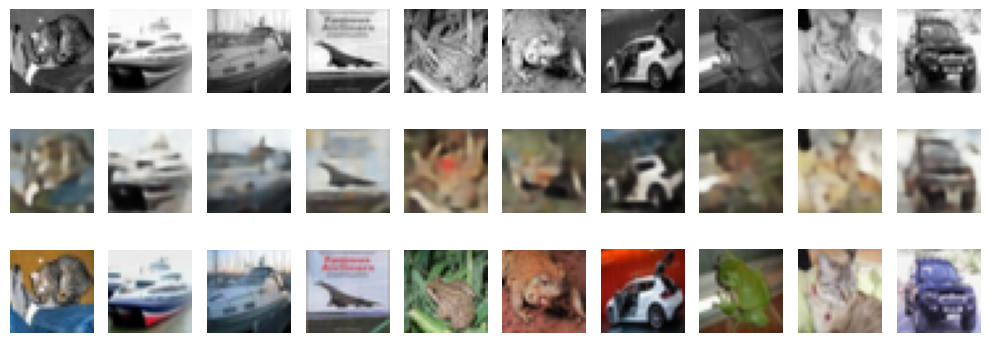

In [ ]:
import matplotlib.pyplot as plt

n = 10
gray_examples = x_test_gray[:n]
color_gt = x_test[:n]

color_pred = autoencoder_loaded.predict(gray_examples)

plt.figure(figsize=(n, 4))
for i in range(n):
    # grayscale input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(gray_examples[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Input\n(gray)", fontsize=10)

    # reconstructed color
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(color_pred[i])
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Predicted\n(color)", fontsize=10)

    # ground truth color
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(color_gt[i])
    plt.axis('off')
    if i == 0:
        ax.set_ylabel("Ground\ntruth", fontsize=10)

plt.tight_layout()
plt.show()
